In [1]:
import os
import json
import pandas as pd
import pandas_profiling
import numpy as np
from scipy import stats
import statsmodels.api as sm
from patsy import dmatrices
from matplotlib import pyplot as plt
import rpy2
import statsmodels.api as smapi
from statsmodels.formula.api import ols
import statsmodels.graphics as smgraphics

In [2]:
%matplotlib inline

# Statistical analysis of feature computations results


## Data importation and manipulation

In [3]:
def get_path_to_all_files(folder_name):
    """Recursively get all filepaths from a directory tree."""

    filepaths = []
    for dirname, dirnames, filenames in os.walk(folder_name):
        for filename in filenames:
            if '.DS_Store' not in filename:
                filepaths.append(os.path.join(dirname, filename))

    return filepaths

### Data importation


In [4]:
results_folder = "/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data"

In [5]:
files = get_path_to_all_files(results_folder)

#### Force plate feature data

In [6]:
fp_files = [file for file in files if "FP" in file]
fp_files[1:5]

['/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/1_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/2_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/3_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/4_3_cop_features.json']

#### Wii Balance Board feature data


In [7]:
wbb_files = [file for file in files if "FP" not in file]
wbb_files[1:5]

['/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/1_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/2_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/3_3_cop_features.json',
 '/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/4_3_cop_features.json']

In [8]:
wbb_files_modified = [filename.replace("BB","FP") for filename in wbb_files]
fp_files_modified = [filename.replace("FP","BB") for filename in fp_files]

In [9]:
fp_files_curated = [file for file in fp_files if file in wbb_files_modified]
wbb_files_curated = [file for file in wbb_files if file in fp_files_modified]

In [10]:
print(fp_files_curated[1])
print(wbb_files_curated[1])
len(fp_files_curated)

/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/FP/1_3_cop_features.json
/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/data/results/feature_data/Repro2/BB/1_3_cop_features.json


72

In [11]:
identical_order_test = [i for i, j in zip(fp_files_curated, wbb_files_curated) if i == j.replace("BB","FP")]

In [12]:
if len(identical_order_test) == len(fp_files_curated):
    print("hello")

hello


###  Data manipulation

In [13]:
def create_index(df):
    arrays = [df["device"].values, df["subject"].values, 
             df["trial"].values, df["balance board"].values]
    tuples = list(zip(*arrays))
    return pd.MultiIndex.from_tuples(tuples, names=['device', 'subject','trial','balance board'])
    

In [14]:
def create_and_merge_dataframes(files):
    time_frames = []
    frequency_frames = []
    for filepath in files:
        with open(filepath) as json_data:
            features = json.load(json_data)     
            time_features = features["time_features"]
            frequency_features = features["frequency_features"]
            
            for dic in (time_features,frequency_features):
                dic["device"] = features["device"]
                dic["subject"] = features["subject"]
                dic["trial"] = features["trial"]
                dic["balance board"] = features["balance board"]

        time_frames.append(pd.DataFrame(time_features, index=[0]))
        frequency_frames.append(pd.DataFrame(frequency_features,index=[0]))
    
    time_features_df = pd.concat(time_frames, axis=0)    
    frequency_features_df = pd.concat(frequency_frames, axis=0)

    df1 = time_features_df.reset_index().drop(['device', 'subject','trial','balance board'], 1)
    df1.index = create_index(time_features_df)
    df1.drop('index', 1, inplace=True)
    df1.sort_index(inplace=True)
    
    df2 = frequency_features_df.reset_index().drop(['device', 'subject','trial','balance board'], 1)
    df2.index = create_index(frequency_features_df)
    df2.drop('index', 1, inplace=True)
    df2.sort_index(inplace=True)
    
    return (df1,df2)

####  WBB  features results merging

In [15]:
wbb_time, wbb_freq = create_and_merge_dataframes(wbb_files)

In [16]:
wbb_time.head()

Mean distance  Mean distance-ML  \
device subject trial balance board                                    
BB     1       1     1                   1.115983          0.789119   
                     2                   0.891037          0.630058   
                     3                   0.890627          0.629768   
                     4                   0.738904          0.522484   
               2     1                   0.718177          0.507828   

                                    Mean distance-AP  Rms distance  \
device subject trial balance board                                   
BB     1       1     1                      2.167205      1.376225   
                     2                      0.970159      1.144056   
                     3                      1.572982      1.128650   
                     4                      1.659343      0.878929   
               2     1                      2.722405      0.850423   

                                    Rms distance-ML  Rms distance-AP  \
device subject trial balance board                                     
BB     1       1     1                     0.973138         2.539252   
                     2                     0.808970         1.257797   
                     3                     0.798076         1.924535   
                     4                     0.621497         2.057353   
               2     1                     0.601340         3.130240   

                                    Path length  Path length-ML  \
device subject trial balance board                                
BB     1       1     1                64.868622       33.116449   
                     2                48.727545       19.374616   
                     3                59.630368       16.638657   
                     4                61.119674       25.545696   
               2     1                55.801643       25.481442   

                                    Path length-AP  Mean velocity  \
device subject trial balance board                                  
BB     1       1     1                   47.093405       3.243431   
                     2                   38.827325       2.436377   
                     3                   53.278987       2.981518   
                     4                   49.843943       3.055984   
               2     1                   42.925300       2.790082   

                                            ...           Mean velocity-AP  \
device subject trial balance board          ...                              
BB     1       1     1                      ...                   2.354670   
                     2                      ...                   1.941366   
                     3                      ...                   2.663949   
                     4                      ...                   2.492197   
               2     1                      ...                   2.146265   

                                       Range  Range-ML   Range-AP  \
device subject trial balance board                                  
BB     1       1     1              3.176887  4.308547  11.856208   
                     2              4.180000  4.381482   6.480253   
                     3              2.947149  2.979330  10.317321   
                     4              2.221743  3.050034   9.674893   
               2     1              2.185186  2.828736  11.764030   

                                    95% confidence circle area  Sway area  \
device subject trial balance board                                          
BB     1       1     1                               18.715644   2.086276   
                     2                               13.480287   0.970886   
                     3                               12.959815   1.307440   
                     4                                7.276084   1.246899   
               2     1                                6.764714   1.925053   

                 

In [17]:
wbb_freq.head()

Total power-RD  Total power-ML  \
device subject trial balance board                                   
BB     1       1     1                    0.522871        4.582237   
                     2                    0.392941        1.162691   
                     3                    0.354253        2.718497   
                     4                    0.187083        3.080011   
               2     1                    0.179638        6.948924   

                                    Total power-AP  Peak frequency-RD  \
device subject trial balance board                                      
BB     1       1     1                    0.714348               0.25   
                     2                    0.483070               0.15   
                     3                    0.459268               0.15   
                     4                    0.296819               0.15   
               2     1                    0.282798               0.20   

                                    Peak frequency-ML  Peak frequency-AP  \
device subject trial balance board                                         
BB     1       1     1                           0.15               0.25   
                     2                           0.20               0.15   
                     3                           0.30               0.15   
                     4                           0.15               0.30   
               2     1                           0.15               0.25   

                                    50% power frequency-RD  \
device subject trial balance board                           
BB     1       1     1                                0.15   
                     2                                0.15   
                     3                                0.15   
                     4                                0.15   
               2     1                                0.15   

                                    50% power frequency-ML  \
device subject trial balance board                           
BB     1       1     1                                0.15   
                     2                                0.15   
                     3                                0.15   
                     4                                0.15   
               2     1                                0.15   

                                    50% power frequency-AP  \
device subject trial balance board                           
BB     1       1     1                                0.15   
                     2                                0.15   
                     3                                0.15   
                     4                                0.15   
               2     1                                0.15   

                                    80% power frequency-RD  \
device subject trial balance board                           
BB     1       1     1                                0.15   
                     2                                0.15   
                     3                                0.15   
                     4                                0.15   
               2     1                                0.15   

                                    80% power frequency-ML  \
device subject trial balance board                           
BB     1       1     1                                0.15   
                     2                                0.15   
                     3                                0.15   
                     4                                0.15   
               2     1                                0.15   

                                    80% power frequency-AP  
device subject trial balance board                          
BB     1       1     1                                0.15  
                     2                                0.15  
                     3                                0.15  
                    

#### FP  features results merging

In [18]:
fp_time,fp_freq = create_and_merge_dataframes(fp_files)

In [19]:
fp_time.head()

Mean distance  Mean distance-ML  \
device subject trial balance board                                    
FP     1       1     1                   1.903751          1.346155   
                     2                   1.566635          1.107778   
                     3                   1.671081          1.181633   
                     4                   1.465760          1.036449   
               2     1                   1.288969          0.911438   

                                    Mean distance-AP  Rms distance  \
device subject trial balance board                                   
FP     1       1     1                      3.286983      2.396578   
                     2                      1.720915      2.071119   
                     3                      2.734661      2.097962   
                     4                      2.603083      1.790222   
               2     1                      4.107877      1.609091   

                                    Rms distance-ML  Rms distance-AP  \
device subject trial balance board                                     
FP     1       1     1                     1.694636         3.904998   
                     2                     1.464503         2.263366   
                     3                     1.483483         3.422573   
                     4                     1.265878         3.263393   
               2     1                     1.137799         4.729762   

                                    Path length  Path length-ML  \
device subject trial balance board                                
FP     1       1     1               181.617927      108.561418   
                     2               158.972402       72.758348   
                     3               179.528333       73.964999   
                     4               194.671896      104.870698   
               2     1               165.556763       98.612146   

                                    Path length-AP  Mean velocity  \
device subject trial balance board                                  
FP     1       1     1                  122.514825       9.080896   
                     2                  124.855421       7.948620   
                     3                  148.674517       8.976417   
                     4                  142.759131       9.733595   
               2     1                  113.269429       8.277838   

                                            ...           Mean velocity-AP  \
device subject trial balance board          ...                              
FP     1       1     1                      ...                   6.125741   
                     2                      ...                   6.242771   
                     3                      ...                   7.433726   
                     4                      ...                   7.137957   
               2     1                      ...                   5.663471   

                                       Range  Range-ML   Range-AP  \
device subject trial balance board                                  
FP     1       1     1              6.339889  8.450483  19.412340   
                     2              9.163480  9.152372  14.342556   
                     3              5.488164  6.811871  18.441132   
                     4              4.919037  6.833894  15.636206   
               2     1              4.883759  5.903164  18.589986   

                                    95% confidence circle area  Sway area  \
device subject trial balance board                                          
FP     1       1     1                               58.048119  10.380762   
                     2                               45.247759   5.658375   
                     3                               44.359345   7.797539   
                     4                               31.302165   8.357825   
               2     1                               25.938627  11.033390   

                 

In [20]:
fp_freq.head()

Total power-RD  Total power-ML  \
device subject trial balance board                                   
FP     1       1     1                    1.841550       10.989080   
                     2                    1.492155        3.996140   
                     3                    1.294666        8.793084   
                     4                    0.962306        7.937415   
               2     1                    0.852522       16.087325   

                                    Total power-AP  Peak frequency-RD  \
device subject trial balance board                                      
FP     1       1     1                    2.322447               0.20   
                     2                    1.629229               0.15   
                     3                    1.665474               0.15   
                     4                    1.331190               0.70   
               2     1                    1.104260               0.60   

                                    Peak frequency-ML  Peak frequency-AP  \
device subject trial balance board                                         
FP     1       1     1                           0.15               0.25   
                     2                           0.20               0.20   
                     3                           0.30               0.15   
                     4                           0.15               0.30   
               2     1                           0.20               0.35   

                                    50% power frequency-RD  \
device subject trial balance board                           
FP     1       1     1                                0.15   
                     2                                0.15   
                     3                                0.15   
                     4                                0.15   
               2     1                                0.15   

                                    50% power frequency-ML  \
device subject trial balance board                           
FP     1       1     1                                0.15   
                     2                                0.15   
                     3                                0.15   
                     4                                0.15   
               2     1                                0.15   

                                    50% power frequency-AP  \
device subject trial balance board                           
FP     1       1     1                                0.15   
                     2                                0.15   
                     3                                0.15   
                     4                                0.15   
               2     1                                0.15   

                                    80% power frequency-RD  \
device subject trial balance board                           
FP     1       1     1                                0.15   
                     2                                0.15   
                     3                                0.15   
                     4                                0.15   
               2     1                                0.15   

                                    80% power frequency-ML  \
device subject trial balance board                           
FP     1       1     1                                0.15   
                     2                                0.15   
                     3                                0.15   
                     4                                0.15   
               2     1                                0.15   

                                    80% power frequency-AP  
device subject trial balance board                          
FP     1       1     1                                0.15  
                     2                                0.15  
                     3                                0.15  
                    

##### OUTLIER DETECTION !!!
 

In [21]:
wbb_outlier_values = wbb_time[wbb_time["Mean velocity"]==wbb_time["Mean velocity"].max()]
wbb_outlier_values

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Path length,Path length-ML,Path length-AP,Mean velocity,...,Mean velocity-AP,Range,Range-ML,Range-AP,95% confidence circle area,Sway area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Fractal dimension-CC
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
BB,4,1,2,2.401951,1.698436,2.866229,3.93063,2.779375,4.545531,166.851322,62.467442,140.395984,8.342566,...,7.019799,14.122858,15.90891,28.718541,177.663903,19.60306,0.552784,0.325087,0.432951,1.463252


In [22]:
outlier_index = wbb_outlier_values.index.tolist()
outlier_index

[('BB', '4', '1', '2')]

In [23]:
fp_outlier_values = fp_time.loc[(fp_time.index.get_level_values('subject') == outlier_index[0][1])
                                           & (fp_time.index.get_level_values('trial') == outlier_index[0][2]) 
                                           & (fp_time.index.get_level_values('balance board') == outlier_index[0][3])
                                          ]

fp_outlier_values

,,,,Mean distance,Mean distance-ML,Mean distance-AP,Rms distance,Rms distance-ML,Rms distance-AP,Path length,Path length-ML,Path length-AP,Mean velocity,...,Mean velocity-AP,Range,Range-ML,Range-AP,95% confidence circle area,Sway area,Mean frequency,Mean frequency-ML,Mean frequency-AP,Fractal dimension-CC
device,subject,trial,balance board,,,,,,,,,,,,,,,,,,,,,
FP,4,1,2,4.478796,3.166987,5.832138,7.519592,5.317155,10.803902,695.383271,243.969952,601.004582,34.769164,...,30.050229,32.322842,40.361057,103.846677,652.799577,129.847547,1.235529,0.680903,0.910846,1.720496


## Statistical analysis

### General descriptive statistics HTML reports 

In [24]:
wbb_time.head()
wbb_time.index.get_level_values(3)
wbb_time_1 = wbb_time.loc[(wbb_time.index.get_level_values(3)=="1")]

In [25]:
outputfile = "/Users/Antonin/Documents/VUB/semester 4/thesis/validation study/notebooks/results/wbb_data_1_time_domain_report.html"
df_profile = pandas_profiling.ProfileReport(wbb_time_1, bins=50)
df_profile.to_file(outputfile=outputfile)

### Features mean value and standard deviation 

In [26]:
def compute_mean_and_stds(df1, df2):
    """Compute the mean and standard deviation values for each feature and each balance board."""

    wbb_and_fp_results = pd.concat([df1, df2], axis=0) 
    feature_mean_results= wbb_and_fp_results.groupby([wbb_and_fp_results.index.get_level_values(0),wbb_and_fp_results.index.get_level_values(3)]).mean().transpose().stack(0).unstack()
    feature_std_results= wbb_and_fp_results.groupby([wbb_and_fp_results.index.get_level_values(0),wbb_and_fp_results.index.get_level_values(3)]).std().transpose().stack(0).unstack()
    aggregated_results = (feature_mean_results, feature_std_results)
    
    return aggregated_results

In [27]:
time_mean_results, time_std_results = compute_mean_and_stds(wbb_time, fp_time)

In [28]:
time_mean_results.head()

balance board            1                   2                   3            \
device                  BB        FP        BB        FP        BB        FP   
Mean distance     0.990660  1.908536  1.205425  2.314882  1.079846  1.917090   
Mean distance-ML  0.700502  1.349539  0.852364  1.636869  0.763566  1.355588   
Mean distance-AP  2.264986  3.565677  2.286028  3.806461  1.988223  3.088378   
Rms distance      1.292347  2.739657  1.605369  3.169951  1.345578  2.471987   
Rms distance-ML   0.913827  1.937230  1.135168  2.241494  0.951467  1.747959   

balance board            4            
device                  BB        FP  
Mean distance     1.089579  1.926069  
Mean distance-ML  0.770449  1.361936  
Mean distance-AP  2.178060  3.398706  
Rms distance      1.325507  2.432015  
Rms distance-ML   0.937275  1.719694

### Spearman correlation

In [29]:
def compute_spearman_correlation(df1, df2):
    
    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    dfs_2 = [df2.loc[(df2.index.get_level_values(3) == number)] for number in wbb_numbers]
    
    result_dict = {key:{} for key in df1.columns}
    
    for (df1, df2, number) in zip(dfs_1, dfs_2, wbb_numbers):
        # Loop over each feature
        for column in df1.columns:
            x = df1[column]
            y = df2[column]

            # Compute the spearman coefficient(rho) and the corresponding p-value
            rho, p_value = stats.spearmanr(x, y, nan_policy="propagate")

            # Store the results
            result_dict[column][number] = {}
            result_dict[column][number]["p-value"] = p_value
            result_dict[column][number]["rho"] = rho
            
    result_dict_collapsed = {(outer_k, inner_k): inner_v for outer_k in result_dict
               for inner_k, inner_v in result_dict[outer_k].items()}

    aggregated_results = pd.DataFrame.from_dict(result_dict_collapsed).transpose()
    aggregated_results = aggregated_results.unstack().stack(0).unstack()

    return aggregated_results

In [30]:
time_spearman_results = compute_spearman_correlation(wbb_time, fp_time)

In [31]:
time_spearman_results.head()

1                       2            \
                                 p-value       rho       p-value       rho   
95% confidence circle area  4.239284e-05  0.812178  6.924386e-08  0.919421   
Fractal dimension-CC        4.841232e-03  0.632611  5.858427e-03  0.621901   
Mean distance               9.781073e-05  0.789474  2.920600e-07  0.902893   
Mean distance-AP            2.486567e-10  0.960784  1.163516e-08  0.935950   
Mean distance-ML            9.781073e-05  0.789474  2.920600e-07  0.902893   

                                       3                       4            
                                 p-value       rho       p-value       rho  
95% confidence circle area  1.227968e-07  0.913223  7.878415e-10  0.954592  
Fractal dimension-CC        1.704051e-04  0.772727  1.481255e-04  0.777090  
Mean distance               1.361720e-05  0.838843  1.460784e-07  0.911249  
Mean distance-AP            1.490083e-08  0.933884  6.588737e-12  0.975232  
Mean distance-ML            1.361720e-05  0.838843  1.460784e-07  0.911249

In [32]:
wbb_time.columns

Index(['Mean distance', 'Mean distance-ML', 'Mean distance-AP', 'Rms distance',
       'Rms distance-ML', 'Rms distance-AP', 'Path length', 'Path length-ML',
       'Path length-AP', 'Mean velocity', 'Mean velocity-ML',
       'Mean velocity-AP', 'Range', 'Range-ML', 'Range-AP',
       '95% confidence circle area', 'Sway area', 'Mean frequency',
       'Mean frequency-ML', 'Mean frequency-AP', 'Fractal dimension-CC'],
      dtype='object')

### Pearson's correlation coefficient and regression lines equations 


In [33]:
fp_time_cut = fp_time[:wbb_time.shape[0]]

In [34]:
def plot_correlation(df1,df2,name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(7,3,figsize=(15,25),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    #axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df1[column]
        y = df2[column]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        ax.plot(x, y, '.', label='original data')
        ax.plot(x, intercept + slope*x, 'black', label='fitted line', linewidth=0.3)
        ax.set_xlabel('Balance Board')
        ax.set_ylabel('Force plate')
        ax.set_title(column, weight = 600)
        r_squared = round(r_value**2,4)
        ax.text(0.8, 0.4, "p-value = {}".format(round(p_value,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.3, "R\u00b2={}".format(r_squared), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.2, "Slope = {}".format(round(slope,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        ax.text(0.8, 0.1, "Intercept = {}".format(round(intercept,4)), fontsize=9, horizontalalignment='center',
                verticalalignment='center', transform=ax.transAxes)
        #ax.legend()
    plt.savefig("results/{}_correlation_plots.png".format(name), bbox_inches='tight')


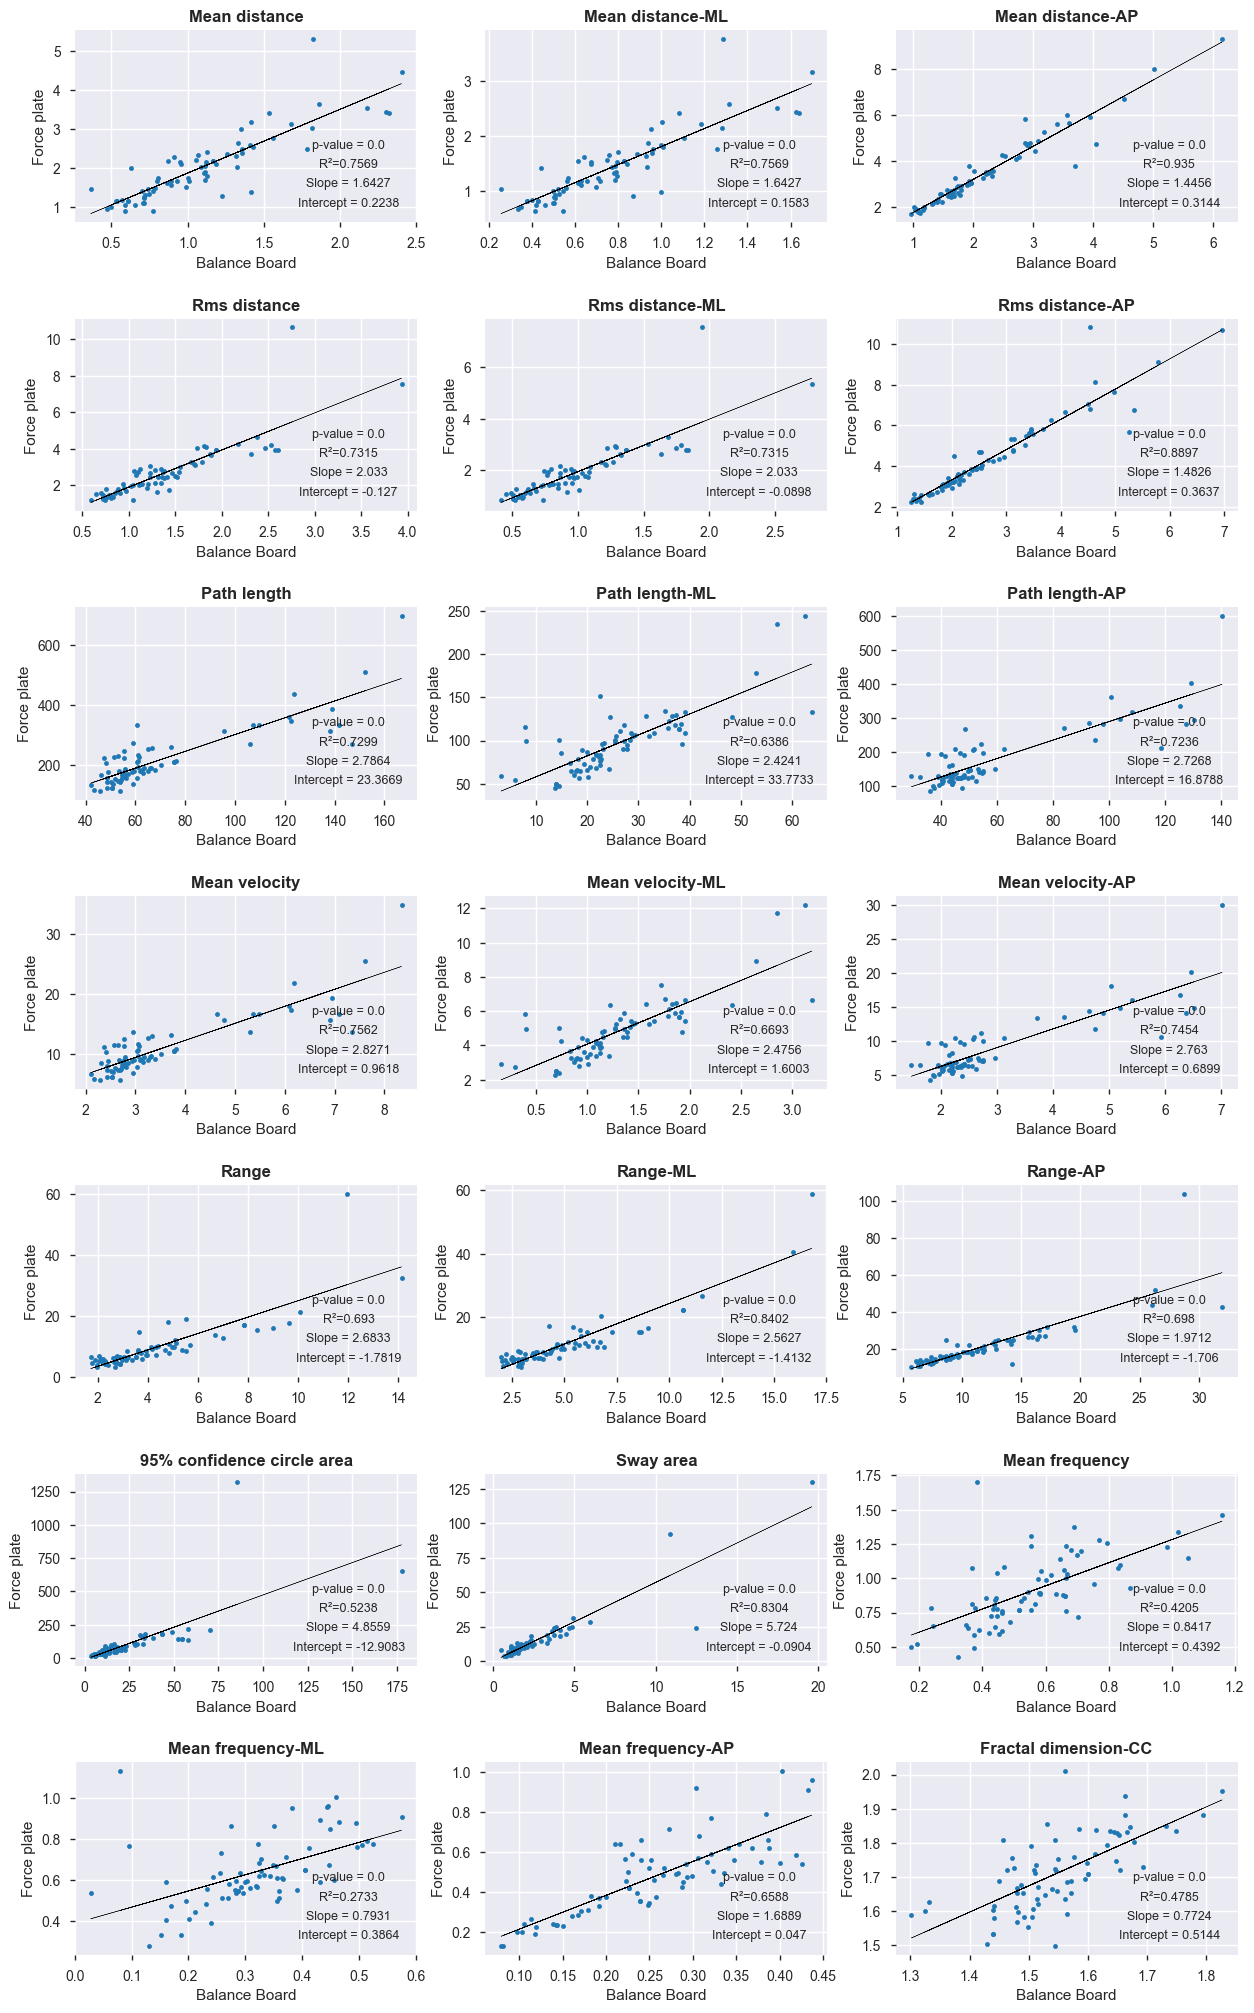

In [35]:
plot_correlation(wbb_time, fp_time_cut)

In [36]:
def plot_correlation_2(df1,df2):
    columns = df1.columns
    fig, axs = plt.subplots(6,3,figsize=(20,30),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    axs[-1, -1].axis('off')
    for ax, column in zip(axs.ravel(), columns):
        x = df1[column]
        y = df2[column]
        regression = ols("data ~ x", data=dict(data=y, x=x)).fit(covtype="scale")
        
        # Find outliers #
        test = regression.outlier_test()
        outliers = ((x[i],y[i]) for i,t in enumerate(test["unadj_p"]) if t < 0.5)
        #print ('Outliers: ', list(outliers))
        
        smgraphics.regressionplots.plot_fit(regression, 1, ax=ax)
        # Add line
        smgraphics.regressionplots.abline_plot(model_results=regression, ax=ax)
        
        #ax.plot(x, y, '.', label='original data')
        ax.set_xlabel('Balance Board')
        ax.set_ylabel('Force plate')
        ax.set_title(column, weight = 600)

        #ax.legend()
    #plt.savefig("results/{}_correlation_plots.png".format(name), bbox_inches='tight')



In [37]:
#plot_correlation_2(wbb_time, fp_time_cut)

### Bland and Altman plots + LOA (limit of agreement)

In [38]:
def bland_altman_plot(df1, df2, name="time_domain"):
    columns = df1.columns
    fig, axs = plt.subplots(6,3,figsize=(20,30),facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5)
    df1= df1.reorder_levels(['balance board','device','subject','trial']).sort_index()
    df2= df2.reorder_levels(['balance board','device','subject','trial']).sort_index()

    for ax, column in zip(axs.ravel(), columns):
        x = df1[column].values
        y = df2[column].values
        data1 = np.asarray(x)
        data2 = np.asarray(y)
        #mean = np.mean([x, y], axis=0)
        trials = [trial for trial in range(len(data1))]
        diff = x - y 
        md = np.mean(diff)               
        sd = np.std(diff, axis=0)

        ax.scatter(trials, diff, marker='.',s=60, color = "gray",  )
        trials_limits = [x * 18 + 0.5 for x in range(1, 4)]
        for limit in trials_limits:
            ax.axvline(limit,color='black', linestyle='--', linewidth=0.5)

        ax.axhline(md,color='tomato', linestyle='--')
        ax.axhline(md + 2*sd, color='teal', linestyle='--', linewidth=0.5)
        ax.axhline(md - 2*sd, color='teal', linestyle='--', linewidth=0.5)
        ax.set_xlabel('Trials')
        ax.set_ylabel('Difference')
        ax.set_title(column, weight = 600)
        
        #ax.legend()
    plt.savefig("results/{}_bland_altman_plots.png".format(name), bbox_inches='tight')

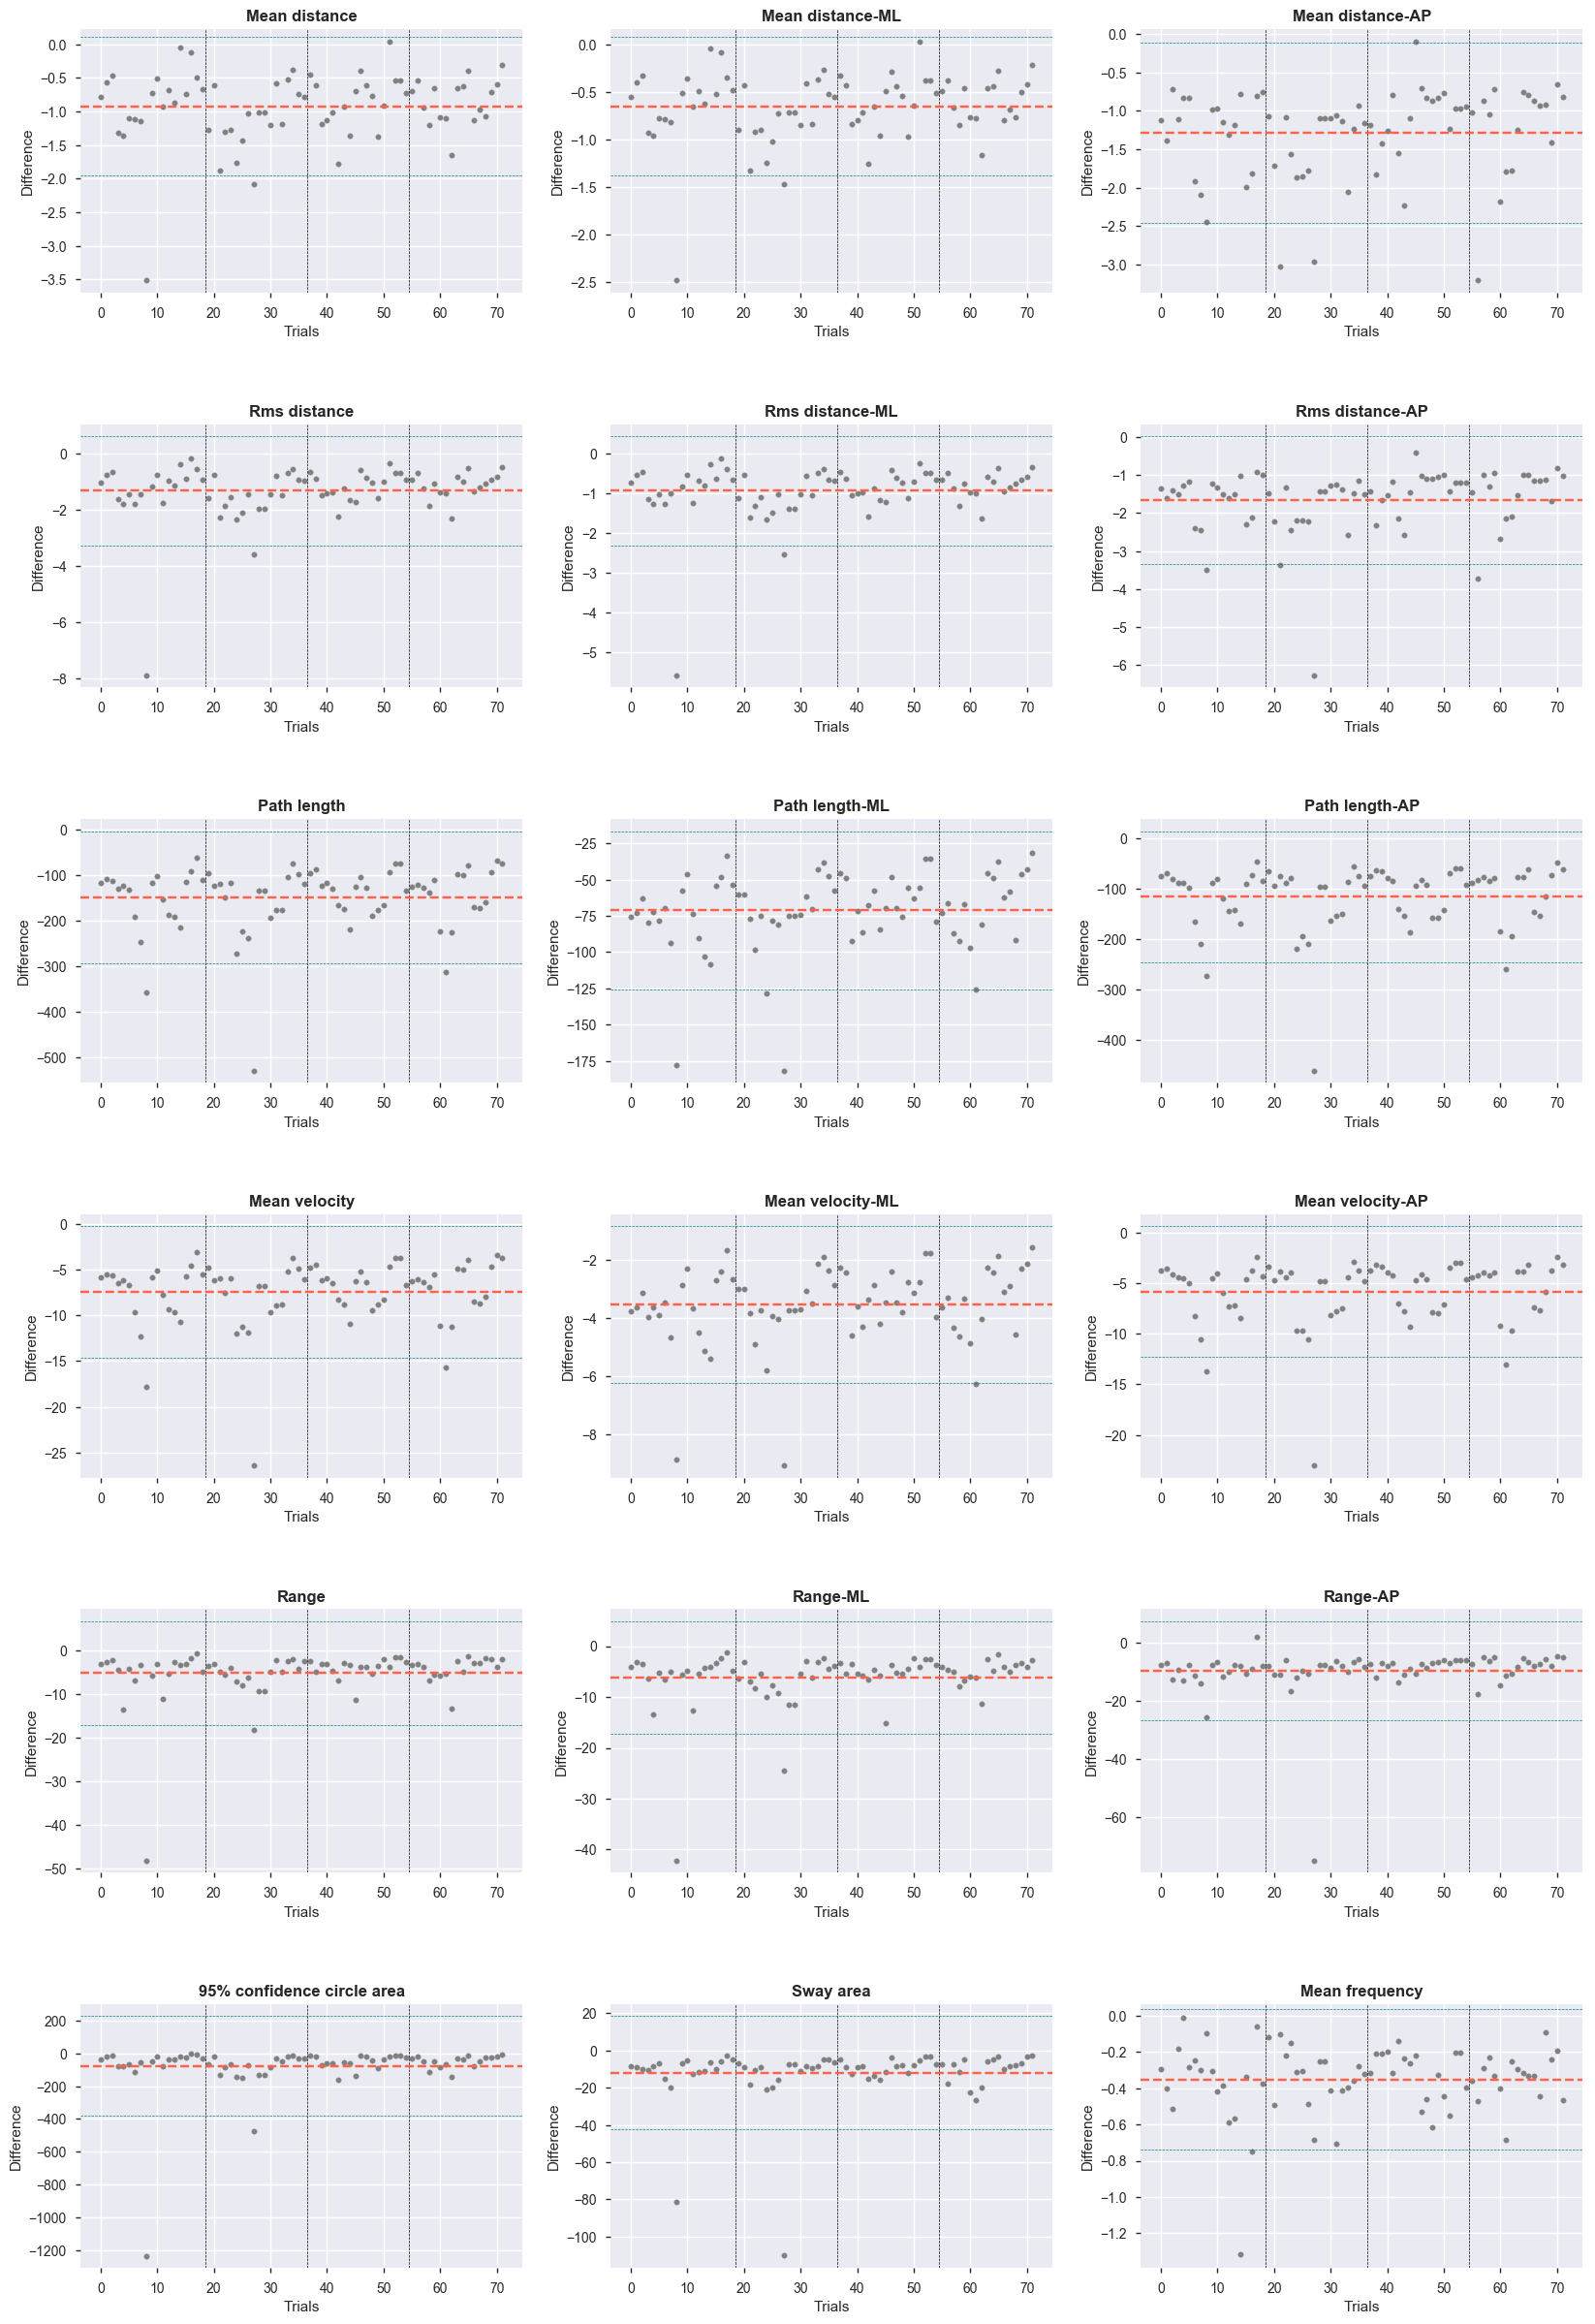

In [39]:
bland_altman_plot(wbb_time,fp_time)

###  Intraclass correlation coefficient (ICC) 



In [40]:
from rpy2.robjects import DataFrame, FloatVector, pandas2ri
from rpy2.robjects.packages import importr

In [41]:
rpy2.__version__

'2.9.5'

In [42]:
def compute_ICC(df1):
    """
    Compute the two-way mixed ICC.

    References
    ----------
    .. [1] R library used for the ICC implementation: http://www.personality-project.org/r/html/ICC.html

    Notes
    -----
    More info on what is the two-way mixed ICC: https://www.uvm.edu/~dhowell/methods8/Supplements/icc/More%20on%20ICCs.pdf
    """

    psych = importr("psych")
    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    result_dict = {}
    # Loop over each feature
    for column in df1.columns:
        r_df = DataFrame({"WBB 1 feature": FloatVector(dfs_1[0][column]),
                              "WBB 2 feature": FloatVector(dfs_1[1][column]),
                              "WBB 3 feature": FloatVector(dfs_1[2][column]),
                              "WBB 4 feature": FloatVector(dfs_1[3][column])})
        # Compute the two way mixed ICC
        icc_res = psych.ICC(r_df)
        iccs_r_df = icc_res[0]

        iccs_df = pandas2ri.ri2py(iccs_r_df)

        # Select the ICC that corresponds to the 2 way mixed model (see links above)
        icc = iccs_df.iloc[4]["ICC"]
        icc_lower_bound = iccs_df.iloc[5]["lower bound"]
        icc_upper_bound = iccs_df.iloc[5]["upper bound"]
        icc_result = "{}({}, {})".format(round(icc, 4), round(icc_lower_bound, 4), round(icc_upper_bound, 4))

        # Store the results
        result_dict[column] = {}
        result_dict[column]["ICC"] = icc_result

    return result_dict

In [43]:
ICC_results = compute_ICC(wbb_time)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: singular fit

  warnings.warn(x, RRuntimeWarning)


In [44]:
ICC_results_df = pd.DataFrame.from_dict(ICC_results).transpose()

In [45]:
ICC_results_df

,ICC
Mean distance,"0.7409(0.4714, 0.8927)"
Mean distance-ML,"0.7409(0.4714, 0.8927)"
Mean distance-AP,"0.7298(0.446, 0.8875)"
Rms distance,"0.7152(0.4308, 0.8844)"
Rms distance-ML,"0.7152(0.4308, 0.8844)"
Rms distance-AP,"0.7512(0.4899, 0.8964)"
Path length,"0.8819(0.758, 0.9509)"
Path length-ML,"0.7418(0.4706, 0.8925)"
Path length-AP,"0.8945(0.7837, 0.9561)"
Mean velocity,"0.9014(0.7978, 0.9589)"


In [46]:
def compute_ICC_2(df1):
    """
    Compute the two-way mixed ICC.

    References
    ----------
    .. [1] R library used for the ICC implementation: https://cran.r-project.org/web/packages/irr/irr.pdf

    Notes
    -----
    More info on what is the two-way mixed ICC: https://www.uvm.edu/~dhowell/methods8/Supplements/icc/More%20on%20ICCs.pdf
    """

    irr = importr("irr")

    wbb_numbers = ["1", "2", "3", "4"]
    dfs_1 = [df1.loc[(df1.index.get_level_values(3) == number)] for number in wbb_numbers]
    result_dict = {}
    # Loop over each feature
    for column in df1.columns:
        r_df = DataFrame({"WBB 1 feature": FloatVector(dfs_1[0][column]),
                              "WBB 2 feature": FloatVector(dfs_1[1][column]),
                              "WBB 3 feature": FloatVector(dfs_1[2][column]),
                              "WBB 4 feature": FloatVector(dfs_1[3][column])})
        # Compute the two way mixed ICC
        icc_res = irr.icc(r_df,"twoway","consistency","average")
        
        result_dict[column] = dict(zip(icc_res.names, list(icc_res)))
        
    return result_dict

In [47]:
ICC_results = compute_ICC_2(wbb_time)

In [48]:
ICC_results_df = pd.DataFrame.from_dict(ICC_results).transpose()

In [49]:
ICC_results_df

,Fvalue,conf.level,df1,df2,icc.name,lbound,model,p.value,r0,raters,subjects,type,ubound,unit,value
Mean distance,[3.878571418982625],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.47143706219632797],[twoway],[8.74899179756762e-05],[0.0],[4],[18],[consistency],[0.8926756176877859],[average],[0.7421731117014454]
Mean distance-ML,[3.878571418982627],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.4714370621963282],[twoway],[8.748991797567569e-05],[0.0],[4],[18],[consistency],[0.892675617687786],[average],[0.7421731117014454]
Mean distance-AP,[3.602607435365716],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.4309485170174523],[twoway],[0.00019807749494677517],[0.0],[4],[18],[consistency],[0.8844544432707915],[average],[0.722423267607983]
Rms distance,[3.601601702271931],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.43078961163151197],[twoway],[0.00019867457558940123],[0.0],[4],[18],[consistency],[0.8844221776290441],[average],[0.7223457553984415]
Rms distance-ML,[3.60160170227193],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.43078961163151186],[twoway],[0.0001986745755894014],[0.0],[4],[18],[consistency],[0.8844221776290441],[average],[0.7223457553984415]
Rms distance-AP,[3.9635326171369667],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.48276719236899635],[twoway],[6.82735453911163e-05],[0.0],[4],[18],[consistency],[0.8949761937125663],[average],[0.7476998181681815]
Path length,[8.22658154602594],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.7507993943499958],[twoway],[2.062625427295597e-09],[0.0],[4],[18],[consistency],[0.9493999689339729],[average],[0.8784428265367314]
Path length-ML,[3.8129160716288357],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.462335633623573],[twoway],[0.00010609479354676929],[0.0],[4],[18],[consistency],[0.8908275781642647],[average],[0.7377335401005009]
Path length-AP,[9.314751294474242],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.7799115576048747],[twoway],[2.4411516045299417e-10],[0.0],[4],[18],[consistency],[0.9553111759362746],[average],[0.892643403094055]
Mean velocity,[9.916911910418545],[0.95],[17.0],[51.0],"[ICC(C,4)]",[0.7932754548777383],[twoway],[8.033285530901101e-11],[0.0],[4],[18],[consistency],[0.9580247071309773],[average],[0.8991621576320128]


In [54]:
power_spectrum = ([1,2,3],[1,5,4])

test = list(zip(power_spectrum[0], power_spectrum[1]))
test

[(1, 1), (2, 5), (3, 4)]

In [52]:
power_spectrum = ([1,2,3],[1,5,4])
for i,j in enumerate(power_spectrum):
    print (i, j)

0 [1, 2, 3]
1 [1, 5, 4]
